In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

import tensorflow as tf

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# импорт данных и создание dataframe

In [29]:


train_dir = r'C:\Users\VoronkovSergey\IT\Melanoma Detection\data\HAM2500\Train'
test_dir = r'C:\Users\VoronkovSergey\IT\Melanoma Detection\data\HAM2500\Test'

# Create dataframes
train_df = pd.DataFrame(columns=['image_path', 'label'])
test_df = pd.DataFrame(columns=['image_path', 'label'])

# Add images paths and labels to dataframes
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)

for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        test_df = test_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
        
# Combine train_df and test_df into one dataframe
df = pd.concat([train_df, test_df], ignore_index=True)
del test_df,train_df
df

,image_path,label
0,C:\Users\VoronkovSergey\IT\Melanoma Detection\...,0
1,C:\Users\VoronkovSergey\IT\Melanoma Detection\...,0
2,C:\Users\VoronkovSergey\IT\Melanoma Detection\...,0
3,C:\Users\VoronkovSergey\IT\Melanoma Detection\...,0
4,C:\Users\VoronkovSergey\IT\Melanoma Detection\...,0
...,...,...
2352,C:\Users\VoronkovSergey\IT\Melanoma Detection\...,7
2353,C:\Users\VoronkovSergey\IT\Melanoma Detection\...,7
2354,C:\Users\VoronkovSergey\IT\Melanoma Detection\...,8
2355,C:\Users\VoronkovSergey\IT\Melanoma Detection\...,8


In [3]:
# Get list of directories in train_dir
labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'actinic keratosis',
 1: 'basal cell carcinoma',
 2: 'dermatofibroma',
 3: 'melanoma',
 4: 'nevus',
 5: 'pigmented benign keratosis',
 6: 'seborrheic keratosis',
 7: 'squamous cell carcinoma',
 8: 'vascular lesion'}

In [30]:
# Get list of directories in train_dir
labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'actinic keratosis',
 1: 'basal cell carcinoma',
 2: 'dermatofibroma',
 3: 'melanoma',
 4: 'nevus',
 5: 'pigmented benign keratosis',
 6: 'seborrheic keratosis',
 7: 'squamous cell carcinoma',
 8: 'vascular lesion'}

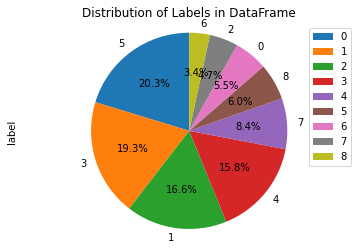

In [4]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [5]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              130       
1               basal cell carcinoma           392       
2               dermatofibroma                 111       
3               melanoma                       454       
4               nevus                          373       
5               pigmented benign keratosis     478       
6               seborrheic keratosis           80        
7               squamous cell carcinoma        197       
8               vascular lesion                142       
------------------------------------------------------------
Total                                         2357      


In [6]:
# загрузка и изменение размера изображения

In [7]:
max_images_per_class = 2500

# Group by label column and take first max_images_per_class rows for each group
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

In [8]:


# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

6

In [10]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

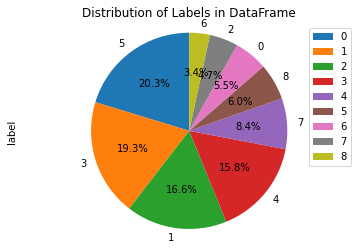

In [11]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [12]:
df.head()

,image_path,label,image
0,D:\Data\HAM2500\Train\actinic keratosis\ISIC_0...,0,"[[[139, 79, 87], [138, 77, 84], [128, 63, 65],..."
1,D:\Data\HAM2500\Train\actinic keratosis\ISIC_0...,0,"[[[114, 85, 85], [96, 66, 60], [86, 64, 69], [..."
2,D:\Data\HAM2500\Train\actinic keratosis\ISIC_0...,0,"[[[166, 120, 116], [170, 126, 122], [175, 132,..."
3,D:\Data\HAM2500\Train\actinic keratosis\ISIC_0...,0,"[[[168, 91, 91], [179, 103, 102], [185, 112, 1..."
4,D:\Data\HAM2500\Train\actinic keratosis\ISIC_0...,0,"[[[206, 155, 156], [206, 156, 157], [211, 164,..."


# Отображение общего количества изображений каждого класса перед увеличением данных

In [13]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              130       
1               basal cell carcinoma           392       
2               dermatofibroma                 111       
3               melanoma                       454       
4               nevus                          373       
5               pigmented benign keratosis     478       
6               seborrheic keratosis           80        
7               squamous cell carcinoma        197       
8               vascular lesion                142       
------------------------------------------------------------
Total                                         2357      


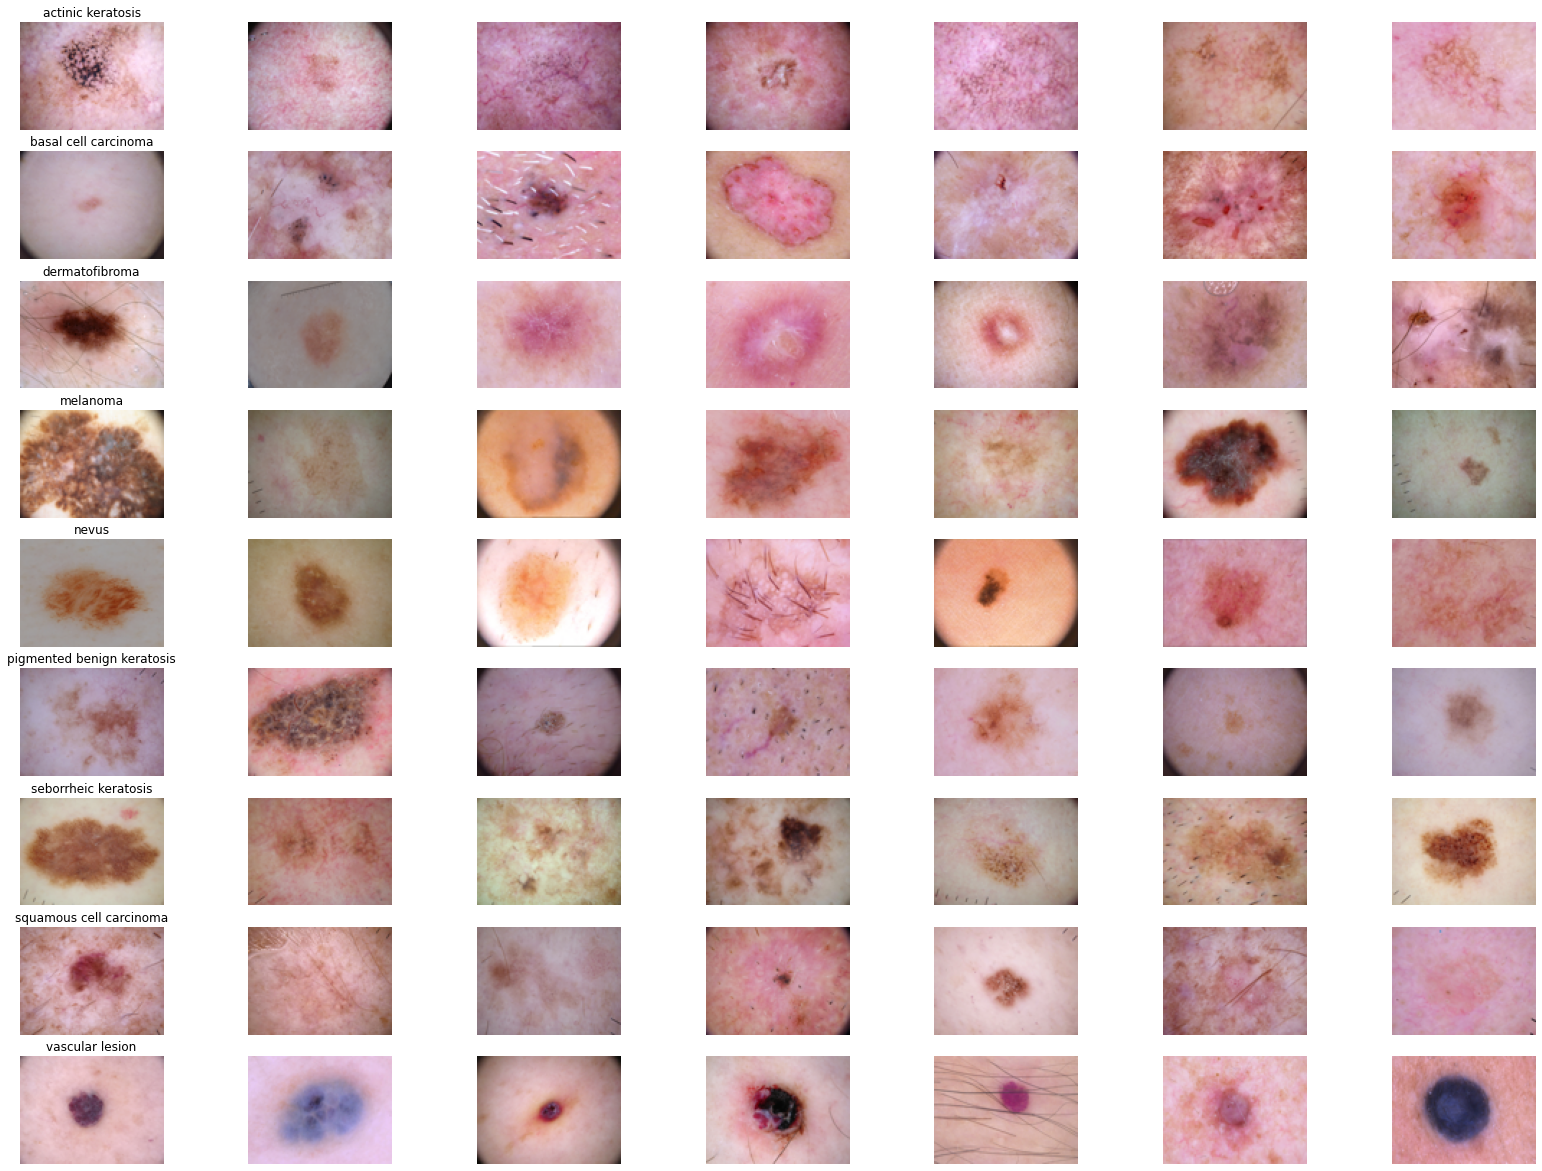

In [14]:
n_samples = 7
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [15]:
df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    2357
Name: image, dtype: int64

# Аугментация

In [16]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [17]:
# Create an empty dataframe to store the augmented images
augmented_df = pd.DataFrame(columns=['image_path', 'label', 'image'])

# Loop through each class label and generate additional images if needed
for class_label in df['label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['label'] == class_label, 'image'].values
    
    # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)
    
    # Generate augmented images for the current class
    if num_images_needed > 0:
        # Select a random subset of the original images
        selected_images = np.random.choice(image_arrays, size=num_images_needed)
        
        # Apply transformations to the selected images and add them to the augmented dataframe
        for image_array in selected_images:
            # Reshape the image array to a 4D tensor with a batch size of 1
            image_tensor = np.expand_dims(image_array, axis=0)
            
            # Generate the augmented images
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            
            # Extract the augmented image arrays and add them to the augmented dataframe
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)
    
    # Add the original images for the current class to the augmented dataframe
    original_images_df = df.loc[df['label'] == class_label, ['image_path', 'label', 'image']]
    augmented_df = augmented_df.append(original_images_df, ignore_index=True)

# Group the augmented dataframe by the 'label' column and filter out extra images
df = augmented_df.groupby('label').head(max_images_per_class)

del augmented_df

# Use the augmented dataframe for further processing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

## Отображение общего количества изображений каждого класса после увеличения данных

In [18]:
# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              130       
1               basal cell carcinoma           392       
2               dermatofibroma                 111       
3               melanoma                       454       
4               nevus                          373       
5               pigmented benign keratosis     478       
6               seborrheic keratosis           80        
7               squamous cell carcinoma        197       
8               vascular lesion                142       
------------------------------------------------------------
Total                                         2357      


# разделение данных

In [19]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [20]:
features[:10]

,image
0,"[[[222, 148, 167], [223, 147, 168], [223, 147,..."
1,"[[[159, 121, 113], [158, 119, 111], [158, 117,..."
2,"[[[198, 147, 140], [198, 147, 140], [199, 147,..."
3,"[[[204, 168, 149], [204, 168, 149], [203, 167,..."
4,"[[[202, 158, 134], [202, 154, 131], [202, 157,..."
5,"[[[161, 150, 139], [160, 148, 137], [158, 146,..."
6,"[[[57, 43, 42], [71, 53, 52], [90, 70, 69], [1..."
7,"[[[251, 243, 222], [251, 242, 222], [251, 242,..."
8,"[[[173, 124, 120], [173, 124, 120], [173, 124,..."
9,"[[[220, 153, 161], [219, 153, 160], [219, 152,..."


In [21]:
print(target.shape,features.shape)

(22500,) (22500, 1)


In [22]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle=True)

# нормализация данных

In [23]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Label Encoding

In [24]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

In [25]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

# split train validation

In [26]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2,shuffle=True)

In [27]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [28]:
x_train.shape

(14400, 75, 100, 3)

In [29]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

In [30]:
# Calculate the number of images in each class for train, validation, and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               actinic keratosis              1630       396          474        2500      
1               basal cell carcinoma           1629       391          480        2500      
2               dermatofibroma                 1580       411          509        2500      
3               melanoma                       1555       426          519        2500      
4               nevus                          1605       424          471        2500      
5               pigmented benign keratosis     1635       388          477        2500      
6               seborrheic keratosis           1610       398          492        2500      
7               squamous cell carcinoma        1602       

In [31]:
df.groupby('label').size()

label
0    2500
1    2500
2    2500
3    2500
4    2500
5    2500
6    2500
7    2500
8    2500
dtype: int64

In [32]:
input_shape = df['image'][0].shape
input_shape

(75, 100, 3)

# model


In [33]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# DenseNet201
model = Sequential()
model.add(DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape))
model.add(Flatten())
model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

74836368/74836368 [==============================] - 3s 0us/step


In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 2, 3, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dropout (Dropout)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 512)               5898752   
                                                                 
 dense_1 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 24,225,353
Trainable params: 23,996,297
Non-trainable params: 229,056
_________________________________________________________________


# optimizer

In [35]:
# compile model
from keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode = 'min' ,verbose=1)

early_stops = [early_stop, learning_rate_reduction]

# fit model

In [36]:
# Fit the model
epochs = 150
batch_size=32
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_validate,y_validate),
#                     callbacks=learning_rate_reduction,
                    callbacks = early_stops,)

Epoch 1/50
450/450 [==============================] - 80s 110ms/step - loss: 1.2146 - accuracy: 0.5698 - val_loss: 0.7461 - val_accuracy: 0.7156 - lr: 0.0010
Epoch 2/50
450/450 [==============================] - 45s 101ms/step - loss: 0.5819 - accuracy: 0.7788 - val_loss: 0.4561 - val_accuracy: 0.8272 - lr: 0.0010
Epoch 3/50
450/450 [==============================] - 45s 99ms/step - loss: 0.3698 - accuracy: 0.8585 - val_loss: 0.4280 - val_accuracy: 0.8528 - lr: 0.0010
Epoch 4/50
450/450 [==============================] - 45s 100ms/step - loss: 0.2587 - accuracy: 0.9018 - val_loss: 0.4515 - val_accuracy: 0.8475 - lr: 0.0010
Epoch 5/50
450/450 [==============================] - 45s 101ms/step - loss: 0.2116 - accuracy: 0.9184 - val_loss: 0.3749 - val_accuracy: 0.8731 - lr: 0.0010
Epoch 6/50
450/450 [==============================] - 46s 102ms/step - loss: 0.1641 - accuracy: 0.9362 - val_loss: 0.2990 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 7/50
450/450 [==============================] -

450/450 [==============================] - 44s 99ms/step - loss: 0.0156 - accuracy: 0.9918 - val_loss: 0.4976 - val_accuracy: 0.9094 - lr: 0.0010
Epoch 42/50
450/450 [==============================] - 46s 103ms/step - loss: 0.0169 - accuracy: 0.9921 - val_loss: 0.5248 - val_accuracy: 0.9111 - lr: 0.0010
Epoch 43/50
450/450 [==============================] - 47s 105ms/step - loss: 0.0174 - accuracy: 0.9922 - val_loss: 0.5244 - val_accuracy: 0.9144 - lr: 0.0010
Epoch 44/50
450/450 [==============================] - 47s 104ms/step - loss: 0.0214 - accuracy: 0.9909 - val_loss: 0.5029 - val_accuracy: 0.9008 - lr: 0.0010
Epoch 45/50
450/450 [==============================] - 47s 103ms/step - loss: 0.0179 - accuracy: 0.9913 - val_loss: 0.5275 - val_accuracy: 0.9139 - lr: 0.0010
Epoch 46/50
450/450 [==============================] - 47s 104ms/step - loss: 0.0140 - accuracy: 0.9926 - val_loss: 0.5200 - val_accuracy: 0.9111 - lr: 0.0010
Epoch 47/50
450/450 [==============================] - 47s 

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Model Evaluation

In [37]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

450/450 [==============================] - 18s 40ms/step - loss: 0.0104 - accuracy: 0.9942
Train: accuracy = 0.994236  ;  loss = 0.010358


In [38]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

141/141 [==============================] - 10s 46ms/step - loss: 0.5436 - accuracy: 0.9078
Testing: accuracy = 0.907778  ;  loss = 0.543630


141/141 [==============================] - 8s 36ms/step


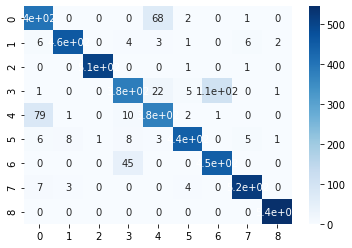

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

Accuracy: 0.9078
Precision: 0.9072
Recall: 0.9062
F1-score: 0.9058
Kappa score: 0.8962


# save model

In [41]:
model.save("skin_melonome_model_DenseNet201.h5")

 # load model

In [3]:
new_model = tf.keras.models.load_model("skin_melonome_model_DenseNet201.h5")

In [4]:
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

In [5]:
df = pd.read_csv(r"C:\Users\VoronkovSergey\IT\Melanoma Detection\data/HAM10000_metadata.csv")

In [6]:
df["path_img"] = r"C:\Users\VoronkovSergey\IT\Melanoma Detection\data\HAM10000\\" + df["image_id"] + ".jpg"

In [7]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path_img
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\VoronkovSergey\IT\Melanoma Detection\...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\VoronkovSergey\IT\Melanoma Detection\...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\VoronkovSergey\IT\Melanoma Detection\...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\VoronkovSergey\IT\Melanoma Detection\...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\VoronkovSergey\IT\Melanoma Detection\...


In [8]:
df = df.drop(columns=["lesion_id", "image_id", "dx_type", "age", "sex", "localization"])

In [78]:
def preprocessing(path:list, model, true_dict, true_disease):
#     print(path)
    for i in path:
#             print(i)
            img = resize_image_array(i)
            img_mean = np.mean(img)
            img_std = np.std(img)
            img = (img-img_mean) / img_std
            img = img[None, ...]
            pred = model.predict(img)
            pred = [list(i).index(i.max()) for i in pred]
            pred = true_dict[pred[0]]
            print("Модель предсказала: {}, правильное значение: {}".format(pred, true_disease))
            return img

In [48]:
dis = os.listdir(r"C:\Users\VoronkovSergey\IT\Melanoma Detection\data\HAM2500\Test")
dis

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [95]:
import random
d = "pigmented benign keratosis"
for i in dis:
    if i == d:
        full_path = f"C:/Users/VoronkovSergey/IT\Melanoma Detection/data/HAM2500/Test/{d}"
        
        s = os.listdir(full_path)
        s = random.choice(s)
#         s = [i for i in s]
        img_p = full_path + "/" + s
#         img_p = [full_path + "/" + j for j in s]
#         print(img_p)
        preprocessing([img_p], new_model, label_map, d)
#         print(img_p)

C:/Users/VoronkovSergey/IT\Melanoma Detection/data/HAM2500/Test/pigmented benign keratosis/ISIC_0024409.jpg
1/1 [==============================] - 0s 87ms/step
Модель предсказала: pigmented benign keratosis, правильное значение: pigmented benign keratosis


In [84]:
a = "C:/Users/VoronkovSergey/IT/Melanoma Detection/data/test.jpg"
a = resize_image_array(a)
a_mean = np.mean(a)
a_std = np.std(a)
a = (a-a_mean) / a_std
a = a[None, ...]
pred = new_model.predict(a)
pred = [list(i).index(i.max()) for i in pred]
label_map[pred[0]]

1/1 [==============================] - 0s 156ms/step


'melanoma'

In [85]:
a = "C:/Users/VoronkovSergey/IT/Melanoma Detection/data/test2.jpg"
a = resize_image_array(a)
a_mean = np.mean(a)
a_std = np.std(a)
a = (a-a_mean) / a_std
a = a[None, ...]
pred = new_model.predict(a)
pred = [list(i).index(i.max()) for i in pred]
label_map[pred[0]]

1/1 [==============================] - 0s 120ms/step


'melanoma'

In [91]:
a = "C:/Users/VoronkovSergey/IT/Melanoma Detection/data/test3.jpg"
a = resize_image_array(a)
a_mean = np.mean(a)
a_std = np.std(a)
a = (a-a_mean) / a_std
a = a[None, ...]
pred = new_model.predict(a)
pred = [list(i).index(i.max()) for i in pred]
pred_pr = [round(i, 10) for i in pred]
print(pred_pr)
label_map[pred[0]]

1/1 [==============================] - 0s 139ms/step
[0]


'actinic keratosis'

In [40]:
[round(i, 4) for i in pred[0]]

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]

In [41]:
pred = [list(i).index(i.max()) for i in pred]

In [42]:
label_map[5]

'pigmented benign keratosis'

In [43]:
pred[0]

5

In [44]:
label_map[pred[0]]

'pigmented benign keratosis'

In [97]:
import json
with open('result.json', 'w') as fp:
    json.dump(label_map, fp)